In [2]:
import litho1pt0 as litho
from pprint import pprint as pprint
import numpy as np

In [3]:
## How to initialise with a different model

# litho1.preprocess_raw_litho1_data("/usr/local/src/LITHO1.0/litho_model","/tmp/truncated")

In [4]:
# litho_data, litho_points = litho1.process_raw_litho1_data("/tmp/truncated")

In [5]:
# litho1.write_processed_litho_data("litho_data.npz", litho_data, litho_points)

# data = np.load("litho_data.npz")
# data.keys()

In [6]:
pprint(" Layer keys")
pprint( litho.l1_layer_decode.items() )
pprint(" Value keys")
pprint( litho.l1_data_decode.items() )

' Layer keys'
[('ASTHENO-TOP', 0),
 ('LID-BOTTOM', 1),
 ('LID-TOP', 2),
 ('CRUST3-BOTTOM', 3),
 ('CRUST3-TOP', 4),
 ('CRUST2-BOTTOM', 5),
 ('CRUST2-TOP', 6),
 ('CRUST1-BOTTOM', 7),
 ('CRUST1-TOP', 8),
 ('SEDS3-BOTTOM', 9),
 ('SEDS3-TOP', 10),
 ('SEDS2-BOTTOM', 11),
 ('SEDS2-TOP', 12),
 ('SEDS1-BOTTOM', 13),
 ('SEDS1-TOP', 14),
 ('WATER-BOTTOM', 15),
 ('WATER-TOP', 16),
 ('ICE-BOTTOM', 17),
 ('ICE-TOP', 18)]
' Value keys'
[('DEPTH', 0),
 ('DENSITY', 1),
 ('VP', 2),
 ('VS', 3),
 ('QKAPPA', 4),
 ('QMU', 5),
 ('VP2', 6),
 ('VS2', 7),
 ('ETA', 8)]


In [8]:
lats = np.array([0,0,0,0])
lons = np.array([10,10,10,10])
depths = np.array([1, 20, 100, 1000])

litho.property_at_lat_lon_depth_points(lats, lons, depths, quantity_ID='VP')


(array([8, 6, 2, 0]), array([6454, 6663, 8127, 7965]))

In [11]:
## Checking the integrity 

nlayers = len(litho.l1_layer_decode)
layer_depths     = np.empty((nlayers, lats.shape[0]))
layer_properties = np.empty((nlayers, lats.shape[0]))


for i in range(0, nlayers, 1 ):   
    layer_depths[i], err =  litho._interpolator.interpolate(lons * np.pi / 180.0, lats * np.pi / 180.0, 
                                                  litho._litho_data[i,litho.l1_data_decode["DEPTH"]])
      
    layer_properties[i], err = litho._interpolator.interpolate( lons * np.pi / 180.0, lats * np.pi / 180.0,
                                          litho._litho_data[i,litho.l1_data_decode["DENSITY"]], order=1)

                    

In [12]:
## make a global raster of some quantity

lonv, latv = np.meshgrid(np.linspace(-180,180,360), np.linspace(-90,90,180), sparse=False, indexing='xy')

l1 = litho.layer_depth(latv, lonv, "LID-BOTTOM")
l2 = litho.layer_depth(latv, lonv, "LID-TOP")

lthickness = (l1 - l2)*0.001

l1 = litho.layer_depth(latv, lonv, "CRUST3-BOTTOM")
l2 = litho.layer_depth(latv, lonv, "CRUST1-TOP")

cthickness = (l1 - l2)*0.001

In [13]:
import pyproj

startlong = -89
startlat  = 40
endlong   = 89
endlat    = 40

g = pyproj.Geod(ellps='WGS84')

(az12, az21, dist) = g.inv(startlong, startlat, endlong, endlat)

# calculate line string along path with segments <= 1 km
lonlats = g.npts(startlong, startlat, endlong, endlat,
                 1 + int(dist / 1000))

# npts doesn't include start/end points, so prepend/append them
lonlats.insert(0, (startlong, startlat))
lonlats.append((endlong, endlat))

lonlats = np.array(lonlats)
print lonlats[0]

[-89.  40.]


In [65]:
def great_circle_profile(ll0, ll1, depths, points, QID):
    """ 
    ll0: (lon0, lat0)
    ll1: (lon1, lat1)
    depths: (km)
    points: number of locations to sample along the profile
    QID: ID of the property to return
    
    """
    startlon  = ll0[0]
    startlat  = ll0[1]
    endlon    = ll1[0]
    endlat    = ll1[1]

    # calculate line string along path with segments <= 1 km

    lonlats = np.degrees(litho.stripy.great_circle_points(np.radians([startlon, startlat]), np.radians([endlon, endlat]), points)).T

    data = np.empty( (lonlats.shape[0], depths.shape[0]))
    
    for s,ll in enumerate(lonlats):

        c, profile = litho.property_on_depth_profile(ll[1], ll[0], depths, QID)   
        data[s,:] = profile[:]


    return lonlats, data
    
    

In [66]:
pll0 = [ 90.0, 0.0]
pll1 = [ 90.0, 40.0]

In [67]:
depths = np.linspace(-10.0, 250, 100)
ll, d = great_circle_profile(pll0, pll1, depths, 100, "VP")


In [68]:
# litho.stripy.great_circle_points() 

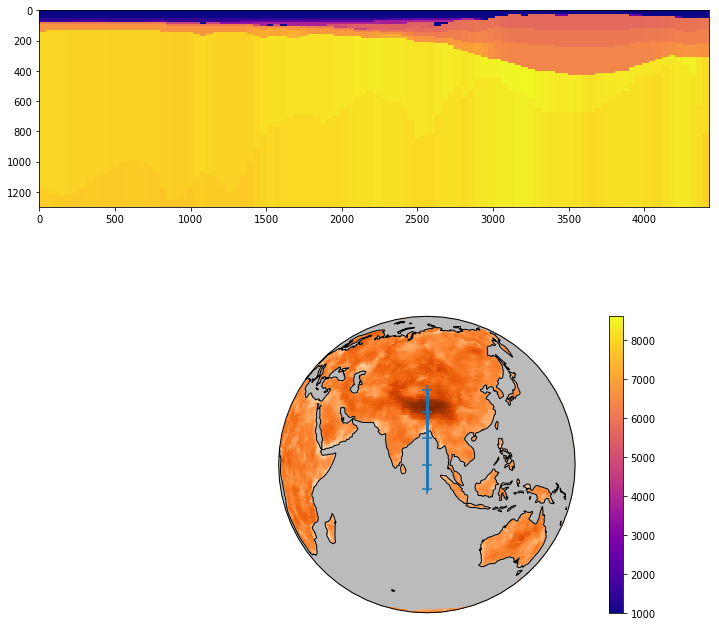

In [69]:
%matplotlib inline

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pyproj

# Compute some properties about the profile line itself

drange = depths[-1] - depths[0]

midlonlat = np.degrees(litho.stripy.great_circle_points(np.radians(pll0), np.radians(pll1), 5)).T

#
# Cross section
#

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(211)
ax2 = plt.subplot(212, projection=ccrs.Orthographic(central_latitude=midlonlat[1][1], 
                                                    central_longitude=midlonlat[1][0]))

image = d[:,:]
m1 = ax.imshow(image.T, origin="upper", cmap="plasma", vmin=1000.0,
                   extent=[0, dist*0.001, drange*5, 0])

plt.colorbar(mappable=m1)



#
# Map / cross section
#

ax2.set_global()
global_extent     = [-180.0, 180.0, -90.0, 90.0]
m = ax2.imshow(cthickness, origin='lower', transform=ccrs.PlateCarree(),
              extent=global_extent, zorder=0, cmap="Oranges")


ax2.add_feature(cartopy.feature.OCEAN, alpha=1.0, facecolor="#BBBBBB")
ax2.coastlines()

ax2.plot( [pll0[0], pll1[0]], [pll0[1], pll1[1]], linewidth=3.0, transform=ccrs.Geodetic(), zorder=100)
ax2.scatter (midlonlat.T[0], midlonlat.T[1], marker="+", s=100, transform=ccrs.Geodetic(), zorder=101)
